In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from pathlib import Path
from matplotlib import gridspec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/creditcardfraud/creditcard.csv


In [3]:
path = Path('/kaggle/input/creditcardfraud/creditcard.csv')
df = pd.read_csv(path)

let's run standard data check. looking for empty cells

In [4]:
df.sample(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
168850,119414.0,2.020765,-0.967323,-1.409797,-0.877021,0.369254,1.551308,-0.871212,0.418395,-0.529123,...,-0.301618,-0.235324,0.300288,-0.946692,-0.453302,0.637371,-0.004462,-0.074363,20.00,0
182380,125372.0,1.817556,0.098325,0.926822,4.090975,-0.686642,0.768119,-0.905461,0.272772,0.270806,...,-0.041591,0.203251,0.299280,0.031108,-0.401301,-0.129334,0.058925,-0.020396,1.00,0
79697,58134.0,1.518334,-0.956920,-0.498684,-1.708495,-0.597479,-0.316279,-0.555302,-0.170220,-2.368379,...,-0.509894,-1.237649,-0.034605,-0.897688,0.452648,-0.398018,-0.008757,-0.000475,48.92,0


In [5]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [6]:
# total number of positive and negative fraud values
df.shape[0],df[df['Class'] == 0].Class.value_counts(),df[df['Class'] == 1].Class.value_counts()

(284807,
 0    284315
 Name: Class, dtype: int64,
 1    492
 Name: Class, dtype: int64)

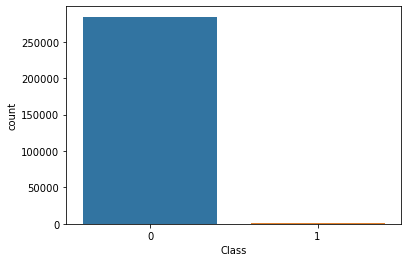

In [7]:
sns.countplot(df.Class)

0 is for normal operations and 1 is for fraud.
there are very few fraud operations , it could be hard to run any binary classifier.
i would like to look for the feature importance first with random forest calssifier

In [8]:
X = df.drop(['Time','Class'],axis=1)
y = df.Class

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [10]:
RFmodel = RandomForestClassifier(n_estimators=100)
RFmodel.fit(X_train,y_train)

RandomForestClassifier()

In [11]:
RFmodel.score(X_test,y_test)

0.9995435553526912

we've got a surprisingly high score

**Feature importance**

(-1.0, 29.0)

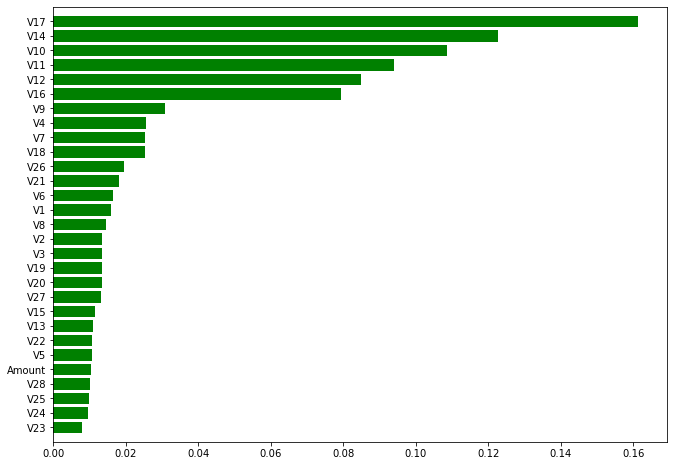

In [12]:
plt.figure(figsize=(11,8))
indices = np.argsort(RFmodel.feature_importances_)
importances = RFmodel.feature_importances_
plt.barh(range(X.shape[1]), importances[indices],color="g")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.ylim(-1,X.shape[1])

Random forest won't perform well with out-of-domain data, is this case due to very low amount of positive results i want to check if top important features fit normal distribution

In [13]:
features_list = X.columns[indices].tolist()
top5 = features_list[-5:]

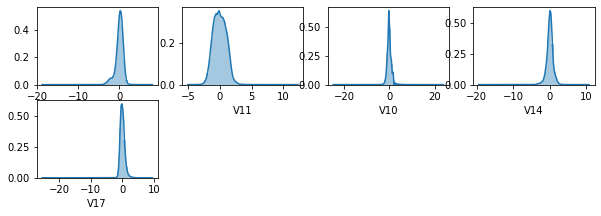

In [14]:
plt.figure(figsize=(10,10))
GS = gridspec.GridSpec(6,4)
for number,feature in enumerate(top5):
    ax = plt.subplot(GS[number])
    sns.distplot(df[feature],bins=50)

data is well centered , probably due to normalization . 
sigma and mu are easy to find ,at this point i will use anomaly detection method as an addition to random forest classifier

**Anomaly detection**

In [15]:
df_ad = df.drop(features_list[:-5],axis=1)

In [16]:
df_ad.drop(['Time'],axis=1,inplace=True)

In [17]:
df_ad.sample(3)

,V10,V11,V12,V14,V17,Class
101997,1.353885,-0.331071,-0.712598,0.026510,0.835405,0
176229,-4.998698,-1.531626,2.323761,1.390137,3.553344,0
18414,-0.752417,0.205337,0.708821,-0.314412,-0.021489,0


perfect.

for the sake of simplicity i took only 5 features. And i'm also not sure that anomaly detection with normal distribution will perform well with many features. We also won't need to reprocess the data in case some features are not well distributed around *mu* . if the importance of the feature is low that's look like too much work and disturbance for very little outcome, if any.

for anymaly detection we need one training set and two test sets(cross validation and final test) with 60% ,20%, 20% size respectively.

In [18]:
df_ad_c1 = df_ad[df_ad.Class == 1]
df_ad_c0 = df_ad[df_ad.Class == 0]

In [19]:
c0_len = len(df_ad_c0)
c1_len = len(df_ad_c1)
c0_len,c1_len

(284315, 492)

In [20]:
df_ad_c1_cv = df_ad_c1.iloc[:c1_len//2]
df_ad_c1_test = df_ad_c1[c1_len//2:]

In [21]:
len(df_ad_c1_cv),len(df_ad_c1_test)

(246, 246)

In [22]:
persent_80 = len(df_ad_c0) - (len(df_ad_c0)//100)*80
persent_80

56875

In [23]:
np.random.seed(10)
drop_indices = np.random.choice(df_ad_c0.index,persent_80,replace=False)

In [24]:
df_ad_c0_cv = df_ad_c0.loc[drop_indices]
df_ad_c0.drop(drop_indices,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
drop_indices_test = np.random.choice(df_ad_c0.index,persent_80,replace=False)
df_ad_c0_test = df_ad_c0.loc[drop_indices_test]
df_ad_c0.drop(drop_indices_test,inplace=True)

In [26]:
len(df_ad_c0_cv), len(df_ad_c0_test)

(56875, 56875)

now i can append dataframes to get full data with both C0 and C1

In [27]:
df_cv_full = df_ad_c1_cv.append(df_ad_c0_cv)
len(df_cv_full)

57121

In [28]:
df_test_full = df_ad_c1_test.append(df_ad_c0_test)
len(df_test_full)

57121

In [29]:
# traning set is df_ad_c0
# cross valid set is df_cv_full
# and test set is df_test_full

**train \ cross valid \ test set**

In [30]:
X_train = df_ad_c0.drop(['Class'],axis=1)
X_cv = df_cv_full.drop(['Class'],axis=1)
X_test = df_test_full.drop(['Class'],axis=1)
y_cv = df_cv_full.Class
y_test = df_test_full.Class

calculating mu and sigma values

In [31]:
def MuSigma(df):
    mu = np.mean(df,axis=0)
    sigma = np.cov(df.T)
    return mu,sigma

In [32]:
mu , sigma = MuSigma(X_train)

We use multiple features for anomaly detection, and we need to calculate multivariate normal for them

In [33]:
def MultivarNormal(df,mu,sigma):
    MN = multivariate_normal(mean=mu,cov=sigma)
    return MN.pdf(df)

In [34]:
MN = MultivarNormal(X_train,mu,sigma)

In [35]:
MN_CV = MultivarNormal(X_cv,mu,sigma)

In [36]:
MN_test = MultivarNormal(X_test,mu,sigma)

ideally i want to loop through all epsilon values , but due to time\perfomance reasons i just can't do that, and will iterate with 1000 or 100 step instead.

In [37]:
MN_sort = np.sort(MN)
s = slice(0,-1,100)
MN_sort_100 = MN_sort[s]

calculating F1 score for the cross validation set

In [38]:
e = 0
total_score = []
total_recall = []
total_precision = []
for f in MN_sort_100:
    e = f
    predscv = MN_CV < e
    f1 = f1_score(y_cv,predscv)
    total_score.append(f1)
    recallcv = recall_score(y_cv,predscv)
    total_recall.append(recallcv)
    preccv = precision_score(y_cv,predscv)
    total_precision.append(preccv)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
MN_sort_100_df = pd.DataFrame(data=MN_sort_100,columns=['epsilon'])
total_score_df = pd.DataFrame(data=total_score,columns=['F1_score'])
total_recall_df = pd.DataFrame(data=total_recall,columns=['total_recall'])
total_precision_df = pd.DataFrame(data=total_precision,columns=['total_precision'])
f1_concat_df = pd.concat([MN_sort_100_df,total_score_df,total_recall_df,total_precision_df],axis=1,sort=False)

**Metrics**

we have sort of binary classification, and recall is primary metric for us. But it's obvious that high recall with precision close to 0 makes no sence. We need both high enough .

In [40]:
# f1_concat_df is our metrics dataframe with all values
f1_concat_df.head(5)

,epsilon,F1_score,total_recall,total_precision
0,0.000000e+00,0.000000,0.000000,0.000000
1,3.750699e-35,0.820084,0.796748,0.844828
2,5.873729e-29,0.786127,0.829268,0.747253
3,5.956707e-24,0.739677,0.837398,0.662379
4,6.119338e-21,0.706282,0.845528,0.606414


accordingly our best epsilon value is

In [41]:
f1_concat_df[f1_concat_df['F1_score'] == f1_concat_df.F1_score.max()].epsilon

1    3.750699e-35
Name: epsilon, dtype: float64

Validating this value with final test set

In [42]:
e_cv_max = f1_concat_df[f1_concat_df['F1_score'] == f1_concat_df.F1_score.max()].epsilon
predstest = MN_test < e_cv_max.values
f_test = f1_score(y_test,predstest)
recall_test = recall_score(y_test,predstest)
prec_test = precision_score(y_test,predstest)

In [43]:
print('f1 score : ',f_test)
print('recall score : ',recall_test)
print('precision score : ',prec_test)

f1 score :  0.7579908675799086
recall score :  0.6747967479674797
precision score :  0.8645833333333334


With these results we catching 2\3 of fraud transactions . it is lower than in cross validation set, but that's the whole point of second test set, which supposed to act like 'new' data.

Main idea of this method - it's very usefull for detecting "out-of-domain" data, and great in combination with regular classifier